# Movie Recommender System

This notebook builds a movie recommendation system using the MovieLens dataset and collaborative filtering.


# Business Understanding

The goal of this project is to build a **Movie Recommendation System** using the MovieLens dataset.  

### Problem Statement
Movie streaming platforms need effective ways to recommend movies that users are likely to enjoy.  
This project applies **collaborative filtering** to recommend movies based on past user ratings.

### Objectives
- Provide personalized movie recommendations.  
- Explore user-item interactions from the MovieLens dataset.  
- Build a baseline recommender using item-based collaborative filtering.  


# Data Understanding

The MovieLens dataset contains multiple CSV files:
- `movies.csv`: movieId, title, genres  
- `ratings.csv`: userId, movieId, rating, timestamp  
- `tags.csv`: userId, movieId, tag, timestamp  
- `links.csv`: movieId, IMDb ID, TMDb ID  

We will primarily use `ratings.csv` and `movies.csv` to build our recommender.


In [5]:
import pandas as pd

# Load data
movies = pd.read_csv("../data/movies.csv")
ratings = pd.read_csv("../data/ratings.csv")
tags = pd.read_csv("../data/tags.csv")
links = pd.read_csv("../data/links.csv")

# Inspect shapes
print("Movies:", movies.shape)
print("Ratings:", ratings.shape)
print("Tags:", tags.shape)
print("Links:", links.shape)

# Preview datasets
display(movies.head())
display(ratings.head())


Movies: (9742, 3)
Ratings: (100836, 4)
Tags: (3683, 4)
Links: (9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## 3. Data Preparation  

In this section, we clean and transform the raw MovieLens datasets to make them ready for analysis and modeling.  
Key tasks include:  
1. Handling missing values.  
2. Removing duplicates.  
3. Converting data types.  
4. Splitting and processing the `genres` column.  
5. Merging datasets (`movies.csv`, `ratings.csv`, `tags.csv`, `links.csv`) into a unified structure.  

This ensures the data is consistent, reliable, and suitable for building our recommender system.


In [6]:
# Check missing values
print("Missing values per dataset:")
print(movies.isnull().sum())
print(ratings.isnull().sum())


# Check duplicates in each dataset
print("Movies duplicates:", movies.duplicated().sum())
print("Ratings duplicates:", ratings.duplicated().sum())


Missing values per dataset:
movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Movies duplicates: 0
Ratings duplicates: 0


## Step 2: Check & Convert Data Types (Movies & Ratings)

For our recommender system, we will mainly use **movies** and **ratings** datasets.  
It is important to ensure that the columns in these two datasets have the correct data types.  

- **Movies dataset**:  
  - `movieId` → should be integer (unique identifier).  
  - `title` → string.  
  - `genres` → string (pipe-separated).  

- **Ratings dataset**:  
  - `userId` → should be integer (unique identifier for each user).  
  - `movieId` → integer (foreign key matching movies).  
  - `rating` → float (numerical rating).  
  - `timestamp` → needs conversion from UNIX time to `datetime` for interpretability.  

Converting timestamps is especially important because it allows us to analyze trends over time and not just by raw numbers.  


In [7]:
# 1. Check data types for movies and ratings
print("Movies dtypes:\n", movies.dtypes, "\n")
print("Ratings dtypes:\n", ratings.dtypes, "\n")

# 2. Convert ratings timestamp from UNIX seconds to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# 3. Confirm conversion
print("Ratings dtypes after conversion:\n", ratings.dtypes, "\n")


Movies dtypes:
 movieId     int64
title      object
genres     object
dtype: object 

Ratings dtypes:
 userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object 

Ratings dtypes after conversion:
 userId                int64
movieId               int64
rating              float64
timestamp    datetime64[ns]
dtype: object 



## Step 4: Splitting and Processing the `genres` Column

The `genres` column in the **movies dataset** contains multiple genres separated by the `|` symbol.  
To make this column easier to work with, we will:  

1. Split genres into individual lists.  
2. Create a one-hot encoded structure where each genre becomes its own column with binary values (0/1).  

This transformation is useful for:  
- Filtering movies by genre.  
- Building content-based recommendation models in the future.  


In [8]:
# Step 4: Split genres into lists
movies['genres'] = movies['genres'].str.split('|')

# Create one-hot encoded dataframe for genres
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(
    mlb.fit_transform(movies['genres']),
    columns=mlb.classes_,
    index=movies.index
)

# Merge back into movies dataframe
movies = movies.join(genres_encoded)

# Preview processed movies dataset
movies.head(5)


,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Step 5: Merging Datasets

To create a unified dataset for our recommender system, we will merge:  

- **ratings.csv** (userId, movieId, rating, timestamp)  
- **movies.csv** (movieId, title, genres)  
- Optionally:  
  - **tags.csv** (userId, movieId, tag, timestamp)  
  - **links.csv** (movieId, external links like IMDb/Movielens/Rotten Tomatoes)  

Merging ensures that all movie ratings are enriched with movie details (title, genres) and can later include tags or external IDs if needed.  


In [9]:
# Step 5: Merge ratings with movies
ratings_movies = ratings.merge(movies, on="movieId", how="left")

# Optionally merge tags
ratings_tags = ratings.merge(tags, on=["userId", "movieId"], how="left")

# Optionally merge links
ratings_movies_links = ratings_movies.merge(links, on="movieId", how="left")

# Preview merged dataset
ratings_movies.head(5)


,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995),"[Action, Crime, Thriller]",0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


# Step 6: Exploratory Data Analysis (EDA)

Now that we have cleaned and merged the data, we can begin exploring it.  
The goal of EDA is to:  
1. Understand the distribution of ratings.  
2. Identify the most popular and highest-rated movies.  
3. Explore user activity patterns.  
4. Analyze genre preferences.  

This step will provide insights into how users interact with movies, and help shape our recommendation strategy.  


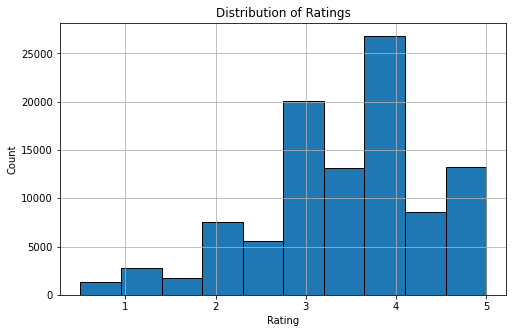

In [10]:
import matplotlib.pyplot as plt

# Distribution of ratings
plt.figure(figsize=(8,5))
ratings['rating'].hist(bins=10, edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


### Ratings Distribution

The histogram shows that most ratings fall between **3.0 and 4.5**, with strong peaks at **3.5 and 4.0**.  
This suggests that users generally rate movies positively, and extreme ratings (very low or very high) are less common.  

**Implications for our recommender system:**  
- Since ratings are skewed towards the higher end, recommendations should prioritize **popular and consistently high-rated movies**.  
- Bias in ratings (few low scores) means collaborative filtering will focus more on user preferences rather than punishing movies with few negative reviews.  


### Number of Ratings per Movie

To understand movie popularity, we calculate how many ratings each movie has received.  
- Movies with more ratings are usually more popular and widely watched.  
- Movies with fewer ratings may be niche or less known.  

This metric is important because:  
- Popular movies tend to dominate collaborative filtering recommendations.  
- Balancing popularity with quality (average rating) helps create fairer recommendations.  


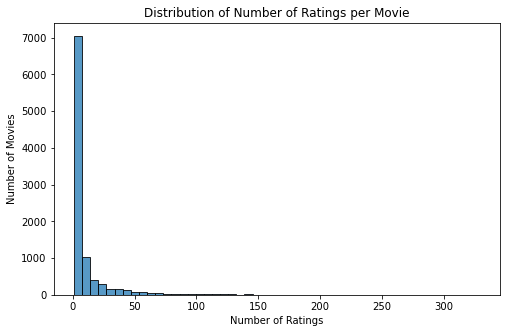

Top 10 Most Rated Movies:
title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: rating, dtype: int64


In [11]:
import seaborn as sns

# Count number of ratings per movie
movie_rating_counts = ratings_movies.groupby('title')['rating'].count().sort_values(ascending=False)

# Plot distribution of number of ratings
plt.figure(figsize=(8,5))
sns.histplot(movie_rating_counts, bins=50, kde=False)
plt.title("Distribution of Number of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.show()

# Show top 10 most rated movies
print("Top 10 Most Rated Movies:")
print(movie_rating_counts.head(10))


The plot shows that most movies have relatively few ratings, while only a handful of movies receive a very large number of ratings.  

- This is a **long-tail distribution**, common in recommender systems.  
- A few movies are extremely popular, while the majority are less known.  
- For collaborative filtering, this imbalance means we should carefully handle rare movies (cold-start problem).  

**Top 10 most rated movies** give us insights into the most watched and reviewed titles in the dataset.  
